# Spiking Neural Networks (SNNs): The Brain-Inspired AI
Spiking Neural Networks (SNNs) are the third generation of artificial neural networks that closely mimic how biological neurons communicate using precise electrical pulses (spikes) rather than continuous values. They are considered more biologically realistic than traditional ANNs and are used in neuromorphic computing for energy-efficient AI.

### **Key Features of SNNs vs. Traditional ANNs**

| Feature                | Traditional ANNs (MLPs, CNNs)       | Spiking Neural Networks (SNNs)       |
|------------------------|-------------------------------------|--------------------------------------|
| **Neuron Model**       | Continuous activations (sigmoid, ReLU) | **Spike-based** (discrete, event-driven) |
| **Information Encoding** | Rate coding (firing frequency)      | **Temporal coding** (exact spike timing) |
| **Learning Rule**      | Backpropagation (gradient-based)    | **STDP/Hebbian learning** (local, unsupervised) |
| **Energy Efficiency**  | High power consumption              | **Ultra-low power** (spikes are sparse) |
| **Hardware**           | GPUs/TPUs                          | **Neuromorphic chips** (Loihi, Akida) |
| **Training Difficulty**| Easy (gradient-based)              | Hard (non-differentiable spikes)     |
| **Biological Plausibility** | Low                              | **High** (mimics real neurons)       |

#### **Key Takeaways:**
- 🚀 **SNNs excel** in energy efficiency and temporal data processing.
- ⚡ **Best for** edge devices, neuromorphic hardware, and brain-like computing.
- ⚠️ **Challenges:** Training complexity and limited software support.

## Leaky Integrate-and-Fire (LIF) Neuron Model

In [34]:
import numpy as np
import matplotlib.pyplot as plt

class LIFNeuron:
    def __init__(self, threshold=0.5, rest_potential=0.0, reset_potential=0.0,
                 membrane_time=10.0, refractory_period=2.0):
        self.threshold = threshold
        self.rest_potential = rest_potential
        self.reset_potential = reset_potential
        self.membrane_time = membrane_time
        self.refractory_period = refractory_period
        
        self.membrane_potential = rest_potential
        self.refractory_counter = 0
        self.spike_times = []
        
    def update(self, input_current, dt=1.0):
        if self.refractory_counter > 0:
            self.refractory_counter -= dt
            self.membrane_potential = self.reset_potential
            return False
        
        noise = np.random.normal(0, 0.05)
        dV = (self.rest_potential - self.membrane_potential + input_current + noise) / self.membrane_time
        self.membrane_potential += dV * dt
        
        if self.membrane_potential >= self.threshold:
            self.membrane_potential = self.reset_potential
            self.refractory_counter = self.refractory_period
            self.spike_times.append(dt)
            return True
        return False

## Spiking Neural Network with STDP Learning

### Spike-Timing-Dependent Plasticity (STDP)
STDP is a biologically inspired unsupervised learning rule that modifies synaptic strength based on the precise timing of spikes between connected neurons. It is a form of Hebbian learning ("neurons that fire together, wire together") but with a temporal dependence.


Key Idea
- If a presynaptic neuron (input) fires before a postsynaptic neuron (output), the synapse is strengthened (Long-Term Potentiation, LTP).

- If the presynaptic neuron fires after, the synapse is weakened (Long-Term Depression, LTD).

This creates a causal relationship where synapses that consistently contribute to firing the postsynaptic neuron are reinforced.

In [45]:
class SNN:
    def __init__(self, n_inputs, n_neurons, n_outputs):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.n_outputs = n_outputs
        
        # Initialize neuron populations
        self.hidden_neurons = [LIFNeuron() for _ in range(n_neurons)]  # This was missing!
        self.output_neurons = [LIFNeuron() for _ in range(n_outputs)]   # This was missing!
        
        # More structured weight initialization
        self.weights_input_hidden = np.random.rand(n_inputs, n_neurons) * 0.5 + 0.3  # 0.3-0.8 range
        self.weights_hidden_output = np.random.rand(n_neurons, n_outputs) * 0.5 + 0.3
        
        # More stable STDP parameters
        self.A_plus = 0.002  # Reduced learning rates
        self.A_minus = 0.0015
        
        # STDP parameters
        self.tau_plus = 20.0
        self.tau_minus = 20.0
        
        # Spike traces
        self.x = np.zeros(n_inputs)
        self.y = np.zeros(n_neurons)
        self.z = np.zeros(n_outputs)
        
    def forward(self, input_spikes, dt=1.0):
        self.x *= np.exp(-dt/self.tau_plus)
        self.y *= np.exp(-dt/self.tau_plus)
        self.z *= np.exp(-dt/self.tau_minus)
        
        input_spike_indices = np.where(input_spikes)[0]
        self.x[input_spike_indices] += 1.0
        
        hidden_input = np.dot(input_spikes, self.weights_input_hidden) * 2.0
        hidden_spikes = np.zeros(self.n_neurons, dtype=bool)
        
        for i, neuron in enumerate(self.hidden_neurons):
            if neuron.update(hidden_input[i], dt):
                hidden_spikes[i] = True
                self.y[i] += 1.0
        
        output_input = np.dot(hidden_spikes, self.weights_hidden_output) * 2.0
        output_spikes = np.zeros(self.n_outputs, dtype=bool)
        
        for i, neuron in enumerate(self.output_neurons):
            if neuron.update(output_input[i], dt):
                output_spikes[i] = True
                self.z[i] += 1.0
        
        return hidden_spikes, output_spikes
    
    def update_weights_stdp(self, input_spikes, hidden_spikes, output_spikes, dt=1.0):
        # Input to Hidden weights
        for i in np.where(input_spikes)[0]:
            for j in np.where(hidden_spikes)[0]:
                dw = self.A_plus * self.x[i] * np.exp(-(self.y[j] * dt)/self.tau_plus)
                self.weights_input_hidden[i,j] += dw
        
        for j in np.where(hidden_spikes)[0]:
            for i in np.where(input_spikes)[0]:
                if not input_spikes[i]:
                    dw = -self.A_minus * self.y[j] * np.exp(-(self.x[i] * dt)/self.tau_minus)
                    self.weights_input_hidden[i,j] = max(0.1, self.weights_input_hidden[i,j] + dw)
        
        # Hidden to Output weights
        for j in np.where(hidden_spikes)[0]:
            for k in np.where(output_spikes)[0]:
                dw = self.A_plus * self.y[j] * np.exp(-(self.z[k] * dt)/self.tau_plus)
                self.weights_hidden_output[j,k] += dw
        
        for k in np.where(output_spikes)[0]:
            for j in np.where(hidden_spikes)[0]:
                if not hidden_spikes[j]:
                    dw = -self.A_minus * self.z[k] * np.exp(-(self.y[j] * dt)/self.tau_minus)
                    self.weights_hidden_output[j,k] = max(0.1, self.weights_hidden_output[j,k] + dw)
        
        self.weights_input_hidden = np.clip(self.weights_input_hidden, 0.1, 1.5)
        self.weights_hidden_output = np.clip(self.weights_hidden_output, 0.1, 1.5)

## Example: Pattern Recognition with SNN

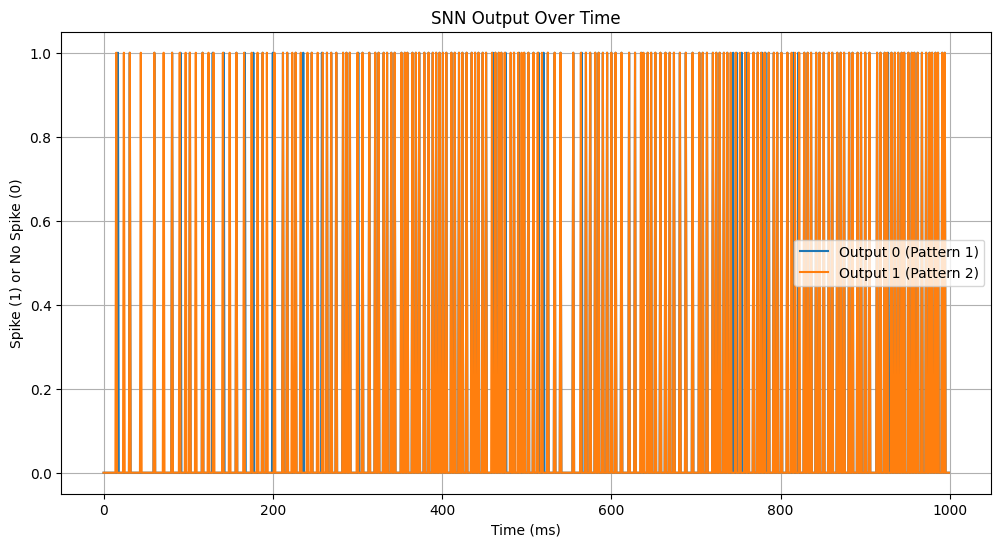

Final input-hidden weights:
[[1.5        1.13941056 1.137164   1.5        1.5       ]
 [0.3906968  0.42127801 0.63312243 0.3806994  0.5078326 ]
 [1.00889892 1.27581811 1.2647714  1.34496897 1.22767074]
 [0.52478208 0.33232458 0.71132259 0.33124933 0.45540118]
 [1.08885651 1.30386491 1.5        1.20966874 0.93370042]
 [1.3204351  0.88870587 1.38400736 1.42618    1.2633684 ]
 [0.3442339  0.76115139 0.3071644  0.60765582 0.5862747 ]
 [0.98531471 1.11695536 1.37243575 0.95206048 1.36578304]
 [0.78465003 0.39553496 0.36068318 0.40673134 0.33267143]
 [1.5        1.5        1.5        1.5        1.09851388]]

Final hidden-output weights:
[[1.23784916 1.5       ]
 [1.21347759 1.3302808 ]
 [1.49832453 1.5       ]
 [1.03972388 1.43654829]
 [1.13649929 1.44275926]]


In [57]:
# Create an SNN with 10 inputs, 5 hidden neurons, and 2 outputs
snn = SNN(n_inputs=10, n_neurons=5, n_outputs=2)

# Simulation parameters
timesteps = 1000
dt = 1.0  # ms

# Training patterns (two different input patterns)
pattern1 = np.array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0])  # Should activate output 0
pattern2 = np.array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1])  # Should activate output 1

# Store outputs for plotting
output0_history = []
output1_history = []

for t in range(timesteps):  # Increased training iterations
    if (t // 500) % 2 == 0:  # Longer pattern duration (500ms)
        input_spikes = (np.random.rand(10) < pattern1 * 0.4)  # Higher spike probability
    else:
        input_spikes = (np.random.rand(10) < pattern2 * 0.4)

    # Forward pass
    hidden_spikes, output_spikes = snn.forward(input_spikes, dt)
    
    # STDP learning
    snn.update_weights_stdp(input_spikes, hidden_spikes, output_spikes, dt)
    
    # Record outputs
    output0_history.append(output_spikes[0])
    output1_history.append(output_spikes[1])

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(output0_history, label="Output 0 (Pattern 1)")
plt.plot(output1_history, label="Output 1 (Pattern 2)")
plt.title("SNN Output Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Spike (1) or No Spike (0)")
plt.legend()
plt.grid(True)
plt.show()

print("Final input-hidden weights:")
print(snn.weights_input_hidden)
print("\nFinal hidden-output weights:")
print(snn.weights_hidden_output)

## Word SNN

In [6]:
import numpy as np

class WordSNN:
    def __init__(self, alphabet_size=26, word_neurons=10, category_neurons=3):
        self.alphabet_size = alphabet_size
        self.word_neurons = word_neurons
        self.category_neurons = category_neurons
        
        # Initialize weights with proper scale
        self.word_weights = np.random.uniform(0.5, 0.7, (alphabet_size, word_neurons))
        self.category_weights = np.random.uniform(0.5, 0.7, (word_neurons, category_neurons))
        
        # Normalize category weights for competition
        self.category_weights /= np.sum(self.category_weights, axis=1, keepdims=True)
        
        # Membrane potentials
        self.word_potentials = np.zeros(word_neurons)
        self.category_potentials = np.zeros(category_neurons)
        
        # STDP parameters
        self.A_plus = 0.2
        self.A_minus = 0.1
        self.word_threshold = 1.2
        self.category_threshold = 1.0
    
    def process_word(self, word, category_idx=None, time_steps=5):
        letters = [ord(c.upper()) - ord('A') for c in word]
        
        # Reset potentials
        self.word_potentials.fill(0)
        self.category_potentials.fill(0)
        
        for t in range(time_steps):
            # Letter layer spikes
            letter_spikes = np.zeros(self.alphabet_size)
            if t < len(letters):
                letter_spikes[letters[t]] = 1
            
            # Word layer integration
            self.word_potentials += np.dot(letter_spikes, self.word_weights)
            word_spikes = (self.word_potentials > self.word_threshold).astype(int)
            
            # Category layer integration with softmax competition
            self.category_potentials += np.dot(word_spikes, self.category_weights)
            category_probs = np.exp(self.category_potentials)
            category_probs /= np.sum(category_probs)
            
            # Learning only if category_idx is provided
            if category_idx is not None and np.max(category_probs) > 0.7:
                # Reward correct category
                if np.argmax(category_probs) == category_idx:
                    # Strengthen active connections
                    active_words = np.where(word_spikes)[0]
                    for w in active_words:
                        self.category_weights[w, category_idx] += self.A_plus
                        # Hebbian learning for letters
                        for l in np.where(letter_spikes)[0]:
                            self.word_weights[l, w] += self.A_plus * (1 - t/time_steps)
                
                # Punish incorrect categories
                else:
                    for w in np.where(word_spikes)[0]:
                        self.category_weights[w, category_idx] -= self.A_minus
        
        # Return final prediction
        return np.argmax(self.category_potentials)

# Initialize and train
snn = WordSNN()
categories = {"Animals": 0, "Verbs": 1, "Places": 2}

# Training data - now with more examples per category
training_data = [
    ("CAT", "Animals"), ("DOG", "Animals"), ("COW", "Animals"),
    ("RUN", "Verbs"), ("EAT", "Verbs"), ("JUMP", "Verbs"),
    ("NYC", "Places"), ("SEA", "Places"), ("SKY", "Places")
]

print("=== Training ===")
for word, category in training_data:
    pred = snn.process_word(word, categories[category])
    print(f"Word: {word:<5} | Target: {category:<7} | Predicted: {list(categories.keys())[pred]}")

# Testing
test_words = ["CAT", "RUN", "SEA", "DOG", "FLY", "ZZZ"]
print("\n=== Testing ===")
for word in test_words:
    pred = snn.process_word(word)  # No category_idx for testing
    print(f"Word: {word:<5} | Predicted: {list(categories.keys())[pred]}")

=== Training ===
Word: CAT   | Target: Animals | Predicted: Verbs
Word: DOG   | Target: Animals | Predicted: Animals
Word: COW   | Target: Animals | Predicted: Animals
Word: RUN   | Target: Verbs   | Predicted: Animals
Word: EAT   | Target: Verbs   | Predicted: Animals
Word: JUMP  | Target: Verbs   | Predicted: Animals
Word: NYC   | Target: Places  | Predicted: Animals
Word: SEA   | Target: Places  | Predicted: Animals
Word: SKY   | Target: Places  | Predicted: Animals

=== Testing ===
Word: CAT   | Predicted: Verbs
Word: RUN   | Predicted: Animals
Word: SEA   | Predicted: Animals
Word: DOG   | Predicted: Animals
Word: FLY   | Predicted: Animals
Word: ZZZ   | Predicted: Animals


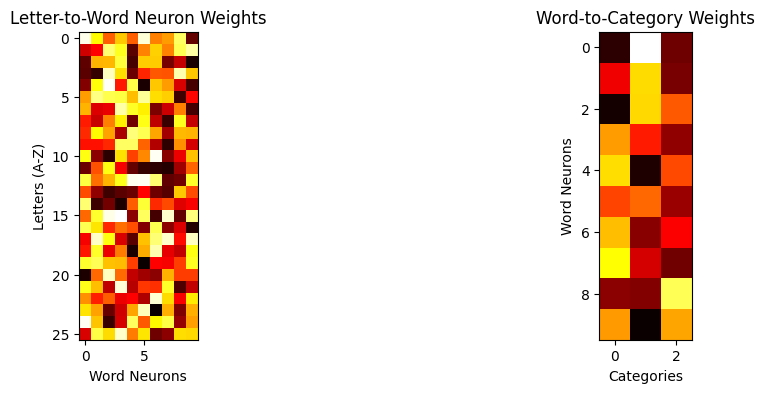

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Letter-to-Word Neuron Weights")
plt.imshow(snn.word_weights, cmap='hot')
plt.xlabel("Word Neurons")
plt.ylabel("Letters (A-Z)")

plt.subplot(122)
plt.title("Word-to-Category Weights")
plt.imshow(snn.category_weights, cmap='hot')
plt.xlabel("Categories")
plt.ylabel("Word Neurons")
plt.show()